# this algorithom using image threshold to achieve the number segmentation


In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

In [2]:
def isIntersection(b1,b2):
    return not(b2[0] > b1[2] or b2[2] < b1[0] or b2[1] > b1[3] or b2[3] < b1[1])

# read original image and resize the image

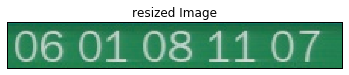

In [3]:
img_ori=cv2.imread("/home/fengsibo/my_project/OCR/image_segmentation/capture/catch1498651049105.jpg",1)

MAX_AREA=img_ori.shape[0]*img_ori.shape[1]

# decide the scale factor
scale=1.0
imgH=img_ori.shape[0]
imgH_ref=img_ori.shape[0]
while (imgH<160):
    scale+=0.1
    imgH=scale*imgH_ref

# resize image
dst=cv2.resize(img_ori,(0,0),fx= scale,fy= scale, interpolation=cv2.INTER_NEAREST)

plt.imshow(dst,cmap = 'gray')
plt.title('resized Image'), plt.xticks([]), plt.yticks([])
plt.show()

# convert color image to gray and reduce the noice

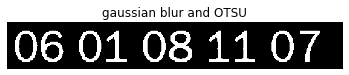

(162, 1188)

In [4]:
img_gray=cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)

blur = cv2.GaussianBlur(img_gray,(5,5),0)
ret,threshold = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

unique, counts = np.unique(threshold, return_counts=True)
thresholdCount=dict(zip(unique, counts))
if (thresholdCount[255]/thresholdCount[0])>1:
    ret,threshold = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.imshow(threshold,cmap = 'gray')
plt.title('gaussian blur and OTSU'), plt.xticks([]), plt.yticks([])
plt.show()
threshold.shape

# Morphological Transformations

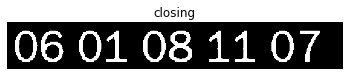

In [5]:
kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

closing = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel)

plt.imshow(closing,cmap = 'gray')
plt.title('closing'), plt.xticks([]), plt.yticks([])
plt.show()

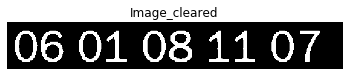

In [6]:
# clear the image border
cleared = clear_border(closing)

plt.imshow(cleared,cmap = 'gray')
plt.title('Image_cleared'), plt.xticks([]), plt.yticks([])
plt.show()

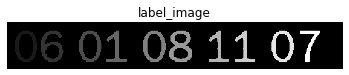

In [7]:
# label the image
label_image = label(cleared)

plt.imshow(label_image,cmap = 'gray')
plt.title('label_image'), plt.xticks([]), plt.yticks([])
plt.show()

# compute bounding box

In [8]:
all_regions=regionprops(label_image)

candidate_regions=[]
valid_regions=[]
isValid=0

padding=4

for region in all_regions:
    # take regions with large enough areas
    if region.area >= MAX_AREA/18:
        minr,minc,maxr,maxc=region.bbox
        candidateBBx=(max(minr-padding,0),max(minc-padding,0),\
                      min(maxr+padding,threshold.shape[0]),min(maxc+padding,threshold.shape[1]))
        candidate_regions.append(candidateBBx)
        
if len(candidate_regions):
    valid_regions=candidate_regions
else:
    for i in range(len(candidate_regions)):
        rr=candidate_regions[i]# reference box
        for j in range(len(candidate_regions)):
            if i==j:
                continue
            cr=candidate_regions[j]#the box to be compared with
            if cr[0]<rr[0] and cr[1]<rr[1] and cr[2]>rr[2] and cr[3]>rr[3]:
                isValid=0
                break
            else:
                isValid=1
        if isValid:
            valid_regions.append(rr)


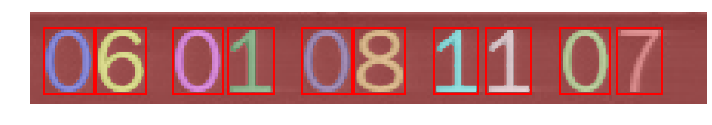

In [9]:
image_label_overlay = label2rgb(label_image, image=dst)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)
for region in valid_regions:
    # take regions with large enough areas
    minr, minc, maxr, maxc = region
    #print region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                            fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
        #print type(region.bbox)
ax.set_axis_off()
plt.tight_layout()
plt.show()